In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil

In [2]:
IMAGE_SIZE = 60
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20
RANDOM_IMAGES_NUMBER = 9999

In [3]:
all_images_0 = os.listdir(r'.\sliced_images_folder\all_images_jpg\no')

In [4]:
random.shuffle(all_images_0)

In [5]:
dir_path = r'.\sliced_images_folder\all_images_less_no\no'
shutil.rmtree(dir_path)

In [6]:
os.mkdir(dir_path)

In [7]:
for i in range (RANDOM_IMAGES_NUMBER):
    original = fr'.\sliced_images_folder\all_images_jpg\no\{all_images_0[i]}'
    target = fr'.\sliced_images_folder\all_images_less_no\no\{all_images_0[i]}'
    shutil.copyfile(original, target)

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'sliced_images_folder/all_images_less_no',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 14498 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [10]:
len(dataset)

454

In [11]:
def get_dataset_partitions_tf(ds, train_split = 0.6, val_split = 0.2, test_split = 0.2, shuffle_size = 10000, shuffle = True):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
print(len(train_ds), len(val_ds), len(test_ds))

272 90 92


In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [18]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val

In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_rue, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true, y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_true, y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision * recall) / (precision + recall + K.epsilon()))

In [20]:
model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(300, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(150, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(75, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'sigmoid')
])

model.build(input_shape = input_shape)

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    #metrics = ['accuracy', f1_metric]# f1 score - precision / recall
    metrics = ['accuracy', f1_metric]
    #metrics = ['acc', f1_m, precision_m, recall_m]
)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 60, 60, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 58, 58, 300)         8400      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 29, 29, 300)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 27, 27, 150)         405150    
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 13, 13, 150)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 11, 11, 75)         

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
272/272 [==============================] - 20s 41ms/step - loss: 0.6324 - accuracy: 0.6854 - f1_metric: 0.4568 - val_loss: 0.6216 - val_accuracy: 0.6909 - val_f1_metric: 0.4668
Epoch 2/20
272/272 [==============================] - 11s 40ms/step - loss: 0.6202 - accuracy: 0.6909 - f1_metric: 0.4668 - val_loss: 0.6184 - val_accuracy: 0.6909 - val_f1_metric: 0.4668
Epoch 3/20
272/272 [==============================] - 11s 40ms/step - loss: 0.6151 - accuracy: 0.6909 - f1_metric: 0.4668 - val_loss: 0.6031 - val_accuracy: 0.6909 - val_f1_metric: 0.4668
Epoch 4/20
272/272 [==============================] - 11s 40ms/step - loss: 0.3828 - accuracy: 0.8439 - f1_metric: 0.4452 - val_loss: 0.2834 - val_accuracy: 0.8990 - val_f1_metric: 0.4360
Epoch 5/20
272/272 [==============================] - 11s 40ms/step - loss: 0.2873 - accuracy: 0.8950 - f1_metric: 0.4430 - val_loss: 0.2756 - val_accuracy: 0.8989 - val_f1_metric: 0.4201
Epoch 6/20
272/272 [==============================] - 11s 40

In [24]:
scores = model.evaluate(test_ds)

272/272 [==============================] - 4s 13ms/step - loss: 0.1901 - accuracy: 0.9415 - f1_metric: 0.4652


In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


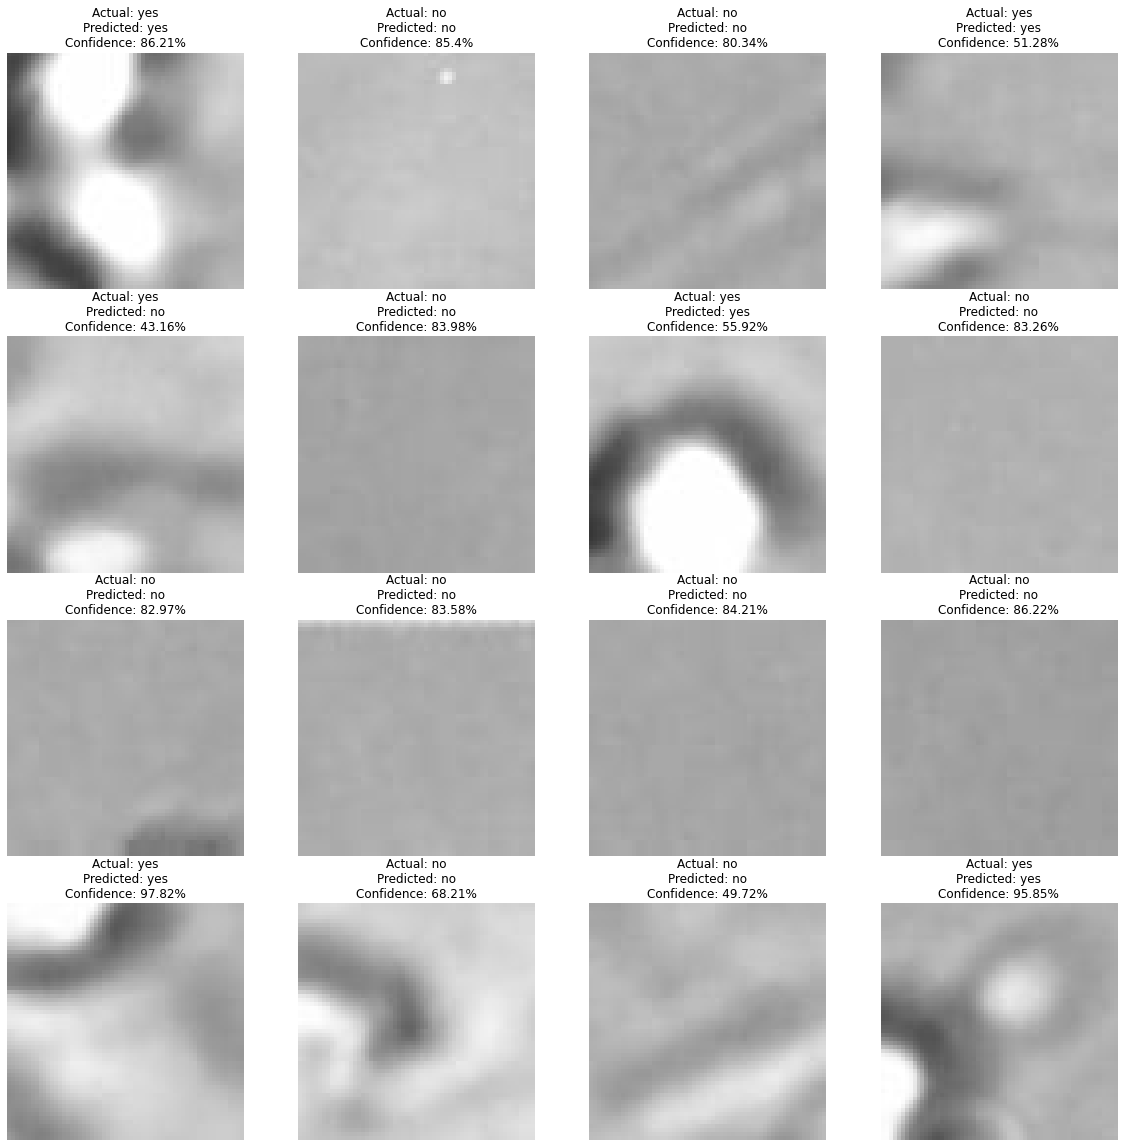

In [29]:
plt.figure(figsize = (20, 20))
for images, labels in test_ds.skip(2).take(1):
    for i in range (16):
        ax = plt.subplot(4,4,i+1) 
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis('off')

In [30]:
model_version = 2
model.save(f'./models/{model_version}')

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets


In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

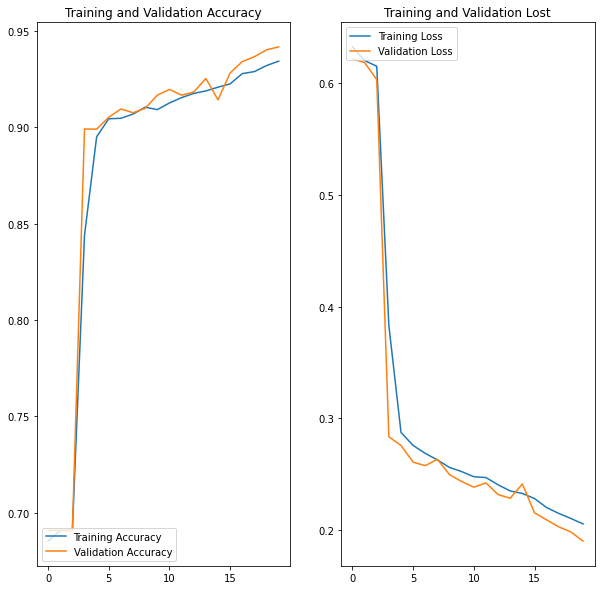

In [32]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.title('Training and Validation Lost')
plt.show()

In [33]:
y_test = []
for images, labels in test_ds:
    for item in labels.numpy():
        y_test.append(item)

In [34]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds, batch_size = 32, verbose = 0)
y_pred_bool = np.argmax(y_pred, axis = 1)
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      5993
           1       0.30      0.29      0.29      2681

    accuracy                           0.57      8674
   macro avg       0.49      0.49      0.49      8674
weighted avg       0.56      0.57      0.57      8674



In [35]:
y_predicted = model.predict(test_ds)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

272/272 [==============================] - 3s 11ms/step


8674
8674


Text(69.0, 0.5, 'Actual')

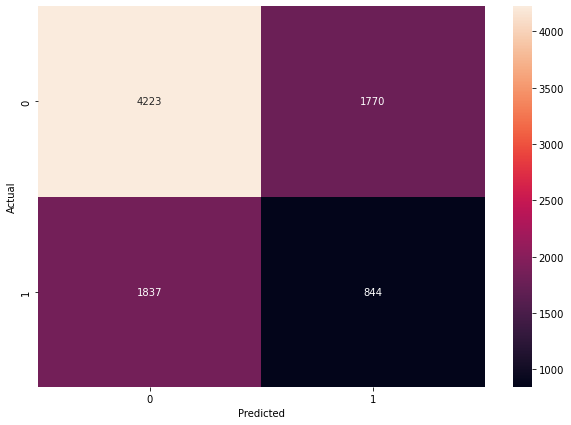

In [38]:
# need to fix this


űprint(len(y_predicted_labels))
print(len(y_test))#272 * 32 = 8675

# print("Actual:",y_test[:20])
# print("Predicted",y_predicted_labels[:20])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)

import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')